# Demographics for Transit Oriented Communities entitlements

Let's take a close look at entitlement applications for Transit Oriented Communities (TOC).

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.inspection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils

import laplan
import utils

cat = intake.open_catalog("../catalogs/*.yml")

First, we load a bunch of relevant data.

In [2]:
# Census tracts
tracts = cat.census_tracts.read().set_index("GEOID")

# Crosswalk from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

In [3]:
joined = utils.entitlements_per_tract(
    suffix_list=["TOC"],
    verbose=True,
    aggregate_years=True,
).fillna({"TOC": 0})

Loading PCTS
Parsing PCTS case numbers
2146 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'HPO', 'VTT', 'APCNV', 'APCSV', 'CPC', 'PS', 'TT', 'APCW', 'APCE', 'AA', 'ENV', 'CHC', 'APCS', 'APCH'}
Loading census analysis table
Loading parcel-tracts crosswalk
Removing cases touching more than 20 parcels
Aggregating entitlements to tract
Joining entitlements to census data


One of our primary variables for TOC entitlements is how many parcels are eligible.
Let's count the number of eligible parcels in each tier on a per-census-tract basis:

In [4]:
tier_parcels = (
    parcel_to_tract
    [parcel_to_tract.TOC_Tier > 0]
    .groupby(["GEOID", "TOC_Tier"])
    .size()
    .to_frame("n")
    .reset_index(level=1)
    .pivot(columns="TOC_Tier", values="n")
    .rename(columns=lambda x: f"Tier_{x}")
    .fillna(0.0)
    .astype(int)
)
tier_parcels

TOC_Tier,Tier_1,Tier_2,Tier_3,Tier_4
GEOID,,,,
06037104320,371,24,0,0
06037104401,166,0,0,0
06037104404,229,31,0,0
06037104610,407,29,0,0
06037104620,230,0,0,0
...,...,...,...,...
06037703100,194,26,0,0
06037703200,24,0,230,52
06037980009,3,0,0,0


In [5]:
n_parcels = parcel_to_tract.groupby("GEOID").size()

Get all of the tracts for which more than 50% of the parcels fall within one TOC tier.
Consider those tracts to be TOC tracts.

In [6]:
toc_eligible_tracts = parcel_to_tract.groupby("GEOID").agg({
    "TOC_Tier": lambda x: True if sum(x > 0)/len(x) >= 0.5 else False
})

Plot up the TOC-eligible tracts:

<AxesSubplot:>

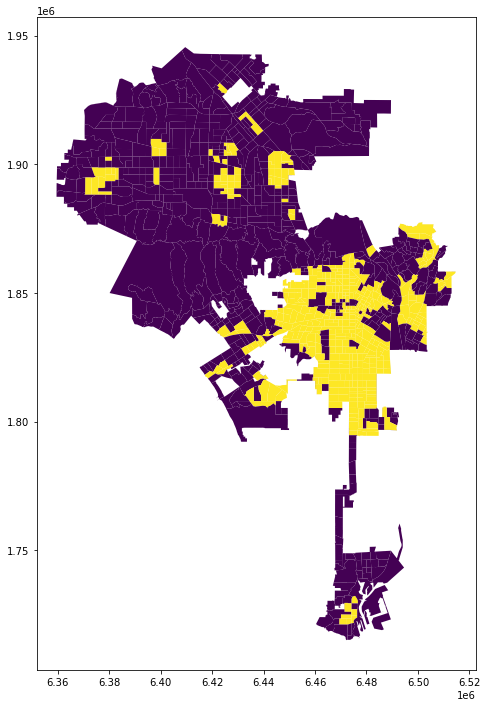

In [7]:
tracts.assign(toc=toc_eligible_tracts).plot(column="toc", figsize=(12,12))

Let's count the number of TOC entitlements per tract:

In [8]:
joined = pandas.merge(
    joined,
    tier_parcels,
    how="left",
    left_index=True,
    right_index=True,
).merge(
    toc_eligible_tracts.rename(columns={"TOC_Tier": "TOC_eligible"}),
    how="left",
    left_index=True,
    right_index=True
).fillna(0).dropna()

In [9]:
joined

,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,pct_whitenonhisp,...,total_r150to199,total_gt200,total_total,density,TOC,Tier_1,Tier_2,Tier_3,Tier_4,TOC_eligible
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,2516,0.583217,...,109,44,1596,9565.898824,0,0.0,0.0,0.0,0.0,False
06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,2755,0.850571,...,133,192,1256,3168.165623,0,0.0,0.0,0.0,0.0,False
06037101210,171,2770,0.061733,114,0.041155,5247,5987,0.876399,2991,0.494217,...,14,71,2321,23832.521795,0,0.0,0.0,0.0,0.0,False
06037101220,54,1513,0.035691,54,0.035691,2110,3497,0.603374,1694,0.484415,...,43,39,1294,12959.051215,0,0.0,0.0,0.0,0.0,False
06037101300,86,2041,0.042136,10,0.004900,353,4250,0.083059,3503,0.815220,...,195,184,1435,4266.139121,0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037980023,0,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,...,0,0,0,0.000000,0,0.0,0.0,0.0,0.0,False
06037980024,0,144,0.000000,0,0.000000,57,264,0.215909,160,0.606061,...,18,8,86,82.519154,0,0.0,0.0,0.0,0.0,False
06037980026,0,13,0.000000,0,0.000000,8,17,0.470588,8,0.216216,...,4,0,8,3.169424,0,0.0,0.0,0.0,0.0,False


In [10]:
joined = geopandas.GeoDataFrame(joined, geometry=tracts.geometry)

## Demographics of TOC tracts

Let's investigate the demographic differences between TOC tracts and non-toc tracts.

In order to do so in a population-normalized way, we have to use population totals rather than percentages.

In [11]:
non_toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[False]
toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[True]
income_cols = [c for c in joined.columns if c.startswith("total_")]
demo_cols = [
    "non_car_workers",
    "zero_veh_workers",
    "pop_renter",
    "pop_whitenonhisp",
]
toc_pop_totals = joined.groupby("TOC_eligible")[[
    "pop_total",
    *demo_cols,
    *income_cols,
]].sum().astype("float")

In [12]:
toc_pop_totals.loc[False, demo_cols] = (
    toc_pop_totals.loc[False, demo_cols] / 
    toc_pop_totals.loc[False, "pop_total"]
)
toc_pop_totals.loc[True, demo_cols] = (
    toc_pop_totals.loc[True, demo_cols] / 
    toc_pop_totals.loc[True, "pop_total"]
)

In [13]:
toc_pop_totals.loc[False, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[False],
        [50],
    )[0]
)
toc_pop_totals.loc[True, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[True],
        [50],
    )[0]
)

In [14]:
toc_pop_totals[demo_cols + ["medhhincome"]].T.style.format("{:.2n}")

TOC_eligible,False,True
non_car_workers,0.048,0.094
zero_veh_workers,0.019,0.046
pop_renter,0.51,0.72
pop_whitenonhisp,0.38,0.17
medhhincome,71,45


## Modeling TOC entitlements

Let's use a Random Forest regressor as a baseline model for relating TOC permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [15]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "Tier_1",
    "Tier_2",
    "Tier_3",
    "Tier_4",
]
target = "TOC"

In [16]:
to_fit = joined.dropna()[variables + [target, "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

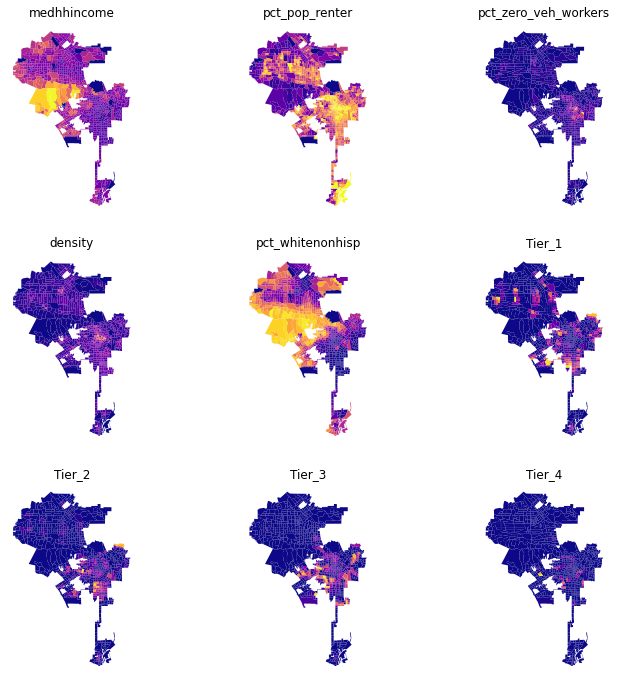

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, var in enumerate(variables):
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var, cmap="plasma")
    ax.axis("off")
    ax.set_title(var)

Filter to only fit counts in tracts that have *some* eligible parcels:

In [18]:
to_fit = to_fit[
    (to_fit.Tier_1 > 0) |
    (to_fit.Tier_2 > 0) |
    (to_fit.Tier_3 > 0) |
    (to_fit.Tier_4 > 0)
]

In [19]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=10)),
])

In [20]:
def plot_model(predictions):
    vmin=0
    vmax=0.15
    cmap="plasma"
    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual TOC/parcel")
    (tracts
     .assign(
         TOC=to_fit.TOC,
         norm_TOC=to_fit.TOC.divide(n_parcels.loc[to_fit.index]),
     ).fillna({"TOC": 0, "norm_TOC": 0})
     .plot(ax=axes[0],column="norm_TOC", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted TOC/parcel")
    (tracts
     .assign(
         predictions=pandas.Series(predictions, index=to_fit.index),
         norm_pred=pandas.Series(predictions, index=to_fit.index).divide(n_parcels.loc[to_fit.index]),
     )
     .fillna({"predictions": 0, "norm_pred": 0})
     .plot(ax=axes[1],column="norm_pred", cmap=cmap, vmin=vmin, vmax=vmax)
    )
    plt.close(fig)
    return fig

Plot up the model to see how it does:

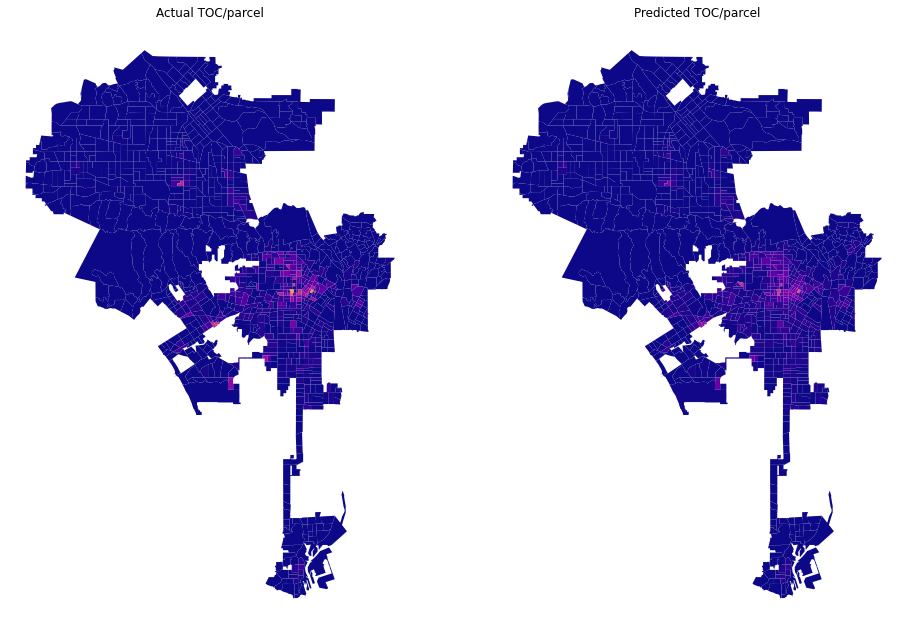

In [21]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[variables]))

In [22]:
print(f"Score: {random_forest_model.score(to_fit[variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=variables,
).sort_values(ascending=False)

Score: 0.8300574872348444


Tier_3                  0.250018
Tier_2                  0.165070
pct_pop_renter          0.161674
density                 0.093508
pct_whitenonhisp        0.086461
pct_zero_veh_workers    0.081964
medhhincome             0.073559
Tier_1                  0.060654
Tier_4                  0.027091
dtype: float64

In [23]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=variables)

medhhincome             0.089808
pct_pop_renter          0.604501
pct_zero_veh_workers    0.139032
density                 0.153750
pct_whitenonhisp        0.117448
Tier_1                  0.106690
Tier_2                  0.355899
Tier_3                  0.571988
Tier_4                  0.025314
dtype: float64

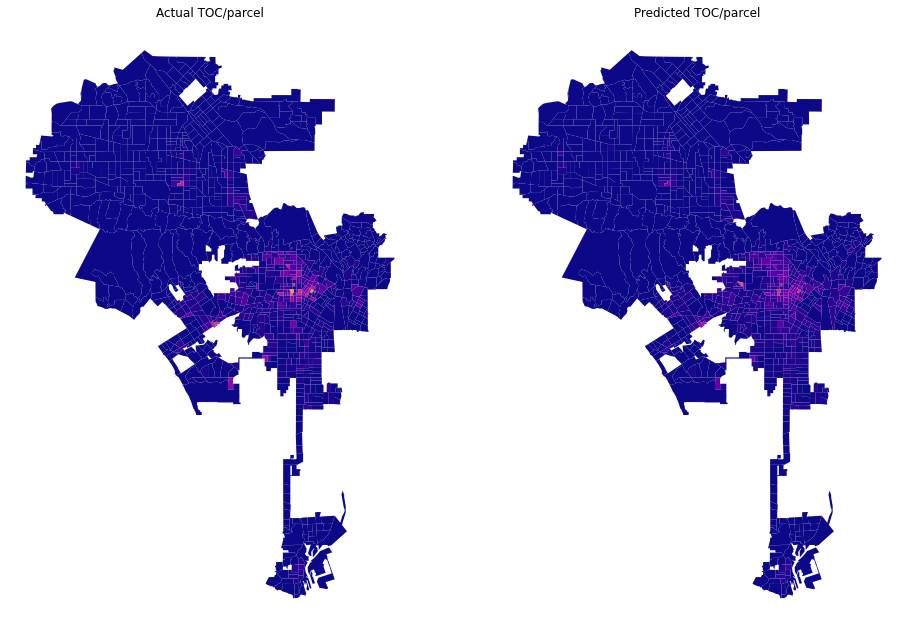

In [24]:
np.random.seed(1)
fewer_variables = [
    "Tier_3",
    "Tier_2",
    "pct_pop_renter",
]

random_forest_model.fit(to_fit[fewer_variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[fewer_variables]))

In [25]:
print(f"Score: {random_forest_model.score(to_fit[fewer_variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=fewer_variables
).sort_values(ascending=False)

Score: 0.8048018142101201


Tier_3            0.388604
pct_pop_renter    0.317571
Tier_2            0.293825
dtype: float64

In [26]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[fewer_variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

Tier_3            0.655228
Tier_2            0.589462
pct_pop_renter    0.713290
dtype: float64

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of TOC entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [27]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, alpha=0, tol=1.e-6))
])

In [28]:
def sample_poisson_model(data, target, norm=1, seed=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    rs = np.random.RandomState(seed)
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                    random_state=rs,
                )
            )
        )
        for i in range(1000)
    ])
    return samples

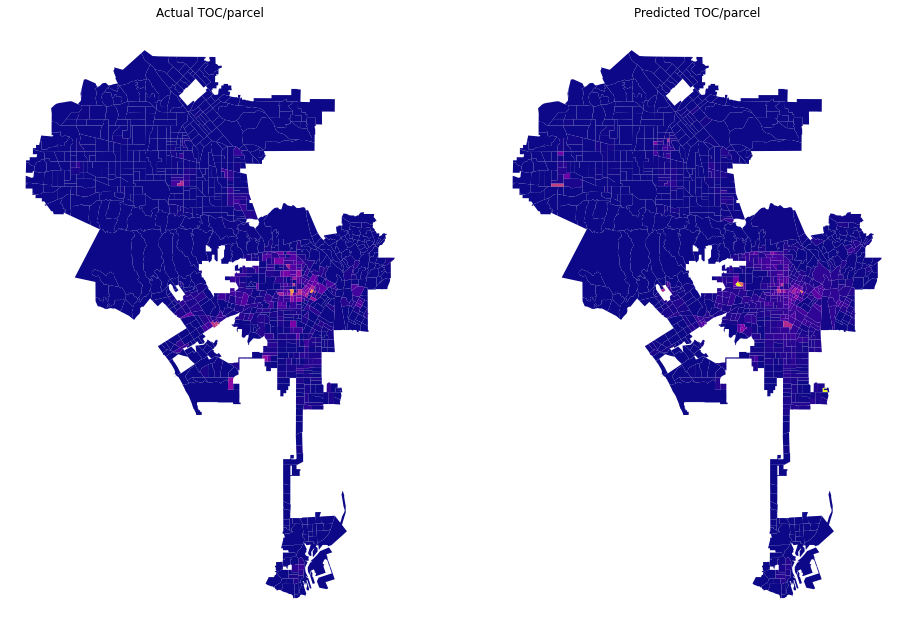

In [29]:
poisson_model.fit(to_fit[fewer_variables], to_fit[target])
plot_model(poisson_model.predict(to_fit[fewer_variables]))

In [30]:
print(f"Poisson Score: {poisson_model.score(to_fit[fewer_variables], to_fit[target].astype('int64'))}")

Poisson Score: 0.289372915504571


In [31]:
imp = sklearn.inspection.permutation_importance(
    poisson_model,
    to_fit[fewer_variables],
    to_fit[target].astype("int64")
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

Tier_3            0.221541
Tier_2            0.136612
pct_pop_renter    0.513599
dtype: float64

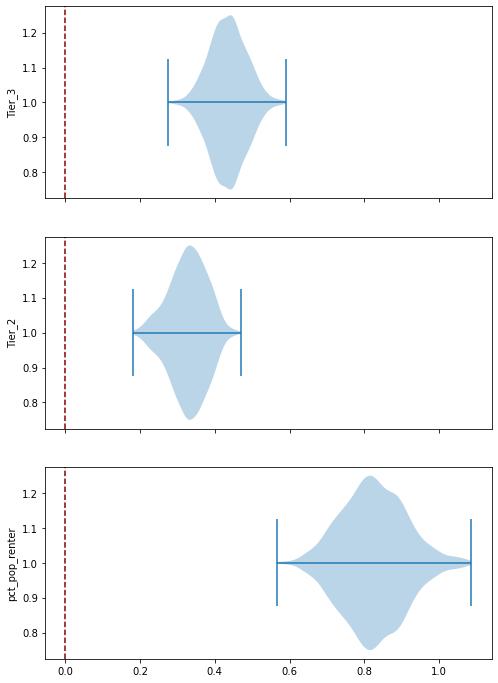

In [32]:
subset = fewer_variables
samples = sample_poisson_model(to_fit[subset], to_fit[target])

fig, axes = plt.subplots(
    len(subset),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,12),

)

for i, var in enumerate(subset):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

#### Interpreting the coefficients

In [33]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [34]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=fewer_variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [35]:
import IPython.display

In [36]:
scale = 100
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 3 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 100
val = (np.exp(beta[1]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 2 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 0.1
val = (np.exp(beta[2]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of renters, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))

For every 100 Tier 3 parcels, there is a 31% increase in TOC entitlements

For every 100 Tier 2 parcels, there is a 33% increase in TOC entitlements

For every 10% increase in population of renters, there is a 36% increase in TOC entitlements